# TASK 3/4. Title Embedding and Cosine Similarity

In this part we computed the embedding for the paper titles, in order to compute the cosine similarity between each pair of titles.

## Imports

In [7]:
#Dask
import dask
from dask.distributed import Client, SSHCluster
import dask.bag as db
import dask.dataframe as dd
import dask.array as da

#Other
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import time
import funky as f

import logging
logging.getLogger("distributed").setLevel(logging.WARNING)


## Cluster / Client setup

In [8]:
cluster = SSHCluster(['localhost', '10.67.22.125', '10.67.22.104', '10.67.22.89'],
                     connect_options={'known_hosts': None},
                     scheduler_options={"port": 8786, "dashboard_address": ":8797", },
                     worker_options={'nthreads':1, 'n_workers':4})
client=Client(cluster)

## PART 3. Embedding the Titles

In the third part we import the pre-trained model `crawl-300d-2M.vec` from FastText, containing two million vectorised words.

We then tokenise the title of each paper and embed it by computing the mean of all the relative tokens.

In [9]:
# Loading titles and paper-ids
meta_block = os.path.getsize('/mnt/data/20/metadata.csv') // 36
meta = dd.read_csv('/mnt/data/20/metadata.csv', blocksize=meta_block, dtype='string')[['cord_uid', 'title']].dropna().drop_duplicates().set_index('cord_uid', sort=False)
meta.npartitions

36

In [10]:
# Tokenising
meta = meta.assign(tokens=meta.title.str.lower().str.strip().str.findall(r'\w+|[^\w\s]'))  # returns a list of tokens for each title
meta = meta.explode("tokens").astype("string")

# Titles' vocabulary to filter the model
unique_words = set(meta.tokens.drop_duplicates().compute())

In [11]:
# Loading the model
model_block = os.path.getsize("/mnt/data/embedding_model/crawl-300d-2M.vec") // 64
model = db.read_text("/mnt/data/embedding_model/crawl-300d-2M.vec", blocksize=model_block).filter(lambda line: not "1999995 300" in line)  # skips header
model.npartitions

64

In [12]:
# filtering the model from unused words
df_model = model.str.split(' ').filter(lambda line: line[0] in unique_words).to_dataframe(meta={"word":"string"} | {str(i): "float16" for i in range(300)}).set_index("word", sort=True)
df_model = df_model.compute()  # I tried to persist it, but then the workers would run out of memory to perform their subsequent tasks

In [13]:
# to save space
del unique_words

In [14]:
# Embedding: inner merge to convert all the available tokens - dropping unused column - computing the tokens mean by title
meta = meta.merge(df_model, right_index=True, left_on="tokens").drop(columns="tokens").groupby("title").mean().astype("float16")

### Results

In [15]:
meta.compute()

/home/ubuntu/miniconda3/envs/mapd/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 16.64 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/ubuntu/miniconda3/envs/mapd/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/ubuntu/miniconda3/envs/mapd/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
title,,,,,,,,,,,,,,,,,,,,,
1 Planning for known and unknown risks,-0.049591,-0.179810,0.031174,-0.082153,0.042358,-0.054108,-0.091370,0.061005,0.062469,-0.048798,...,0.086670,0.024765,-0.001963,0.085388,0.007008,-0.031250,-0.032684,0.002337,0.084473,0.064758
3 Cyber-control in China,0.086487,0.035736,0.037354,-0.067261,0.057068,0.027573,-0.101318,0.039673,0.139038,0.022766,...,0.092163,-0.026749,0.091187,-0.074036,0.035065,0.098816,-0.044769,-0.060486,0.026245,0.065979
3D Models of glycosylated SARS-CoV-2 spike protein suggest challenges and opportunities for vaccine development,-0.020630,0.069641,0.054321,0.014694,0.020966,-0.091797,-0.179932,0.179932,0.041748,0.046661,...,0.008606,0.010254,-0.097900,-0.040833,0.025055,0.072144,-0.085999,-0.017822,0.070923,-0.085022
"4-[1-(Substituted aryl/alkyl carbonyl)-benzoimidazol-2-yl]-benzenesulfonic acids: Synthesis, antimicrobial activity, QSAR studies, and antiviral evaluation",-0.025055,0.063904,0.015030,0.105652,-0.013618,-0.116394,-0.018661,0.018051,-0.120911,-0.022049,...,-0.008537,-0.059387,-0.029892,0.009407,0.047089,-0.018539,0.055084,0.005356,-0.003601,0.048706
A Brief Review of Computer-Assisted Approaches to Rational Design of Peptide Vaccines,0.026215,-0.007805,0.146606,-0.010994,0.022949,-0.034058,-0.093506,-0.002617,-0.048187,-0.018234,...,-0.059937,-0.000781,0.009933,-0.086304,0.014236,0.087646,0.008263,0.069275,0.058075,-0.011566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zika virus-induced acute myelitis and motor deficits in adult interferon αβ/γ receptor knockout mice,0.054535,0.202148,0.219116,0.080811,0.032318,-0.043701,-0.318359,0.163086,-0.066101,0.071838,...,-0.156860,-0.015274,-0.069214,0.127808,0.106262,0.148926,0.023727,-0.041077,0.111328,0.101013
Zinc Chelation Specifically Inhibits Early Stages of Dengue Virus Replication by Activation of NF-κB and Induction of Antiviral Response in Epithelial Cells,0.090393,0.119080,0.031891,0.038269,-0.065674,-0.041870,-0.279053,0.077576,-0.176392,-0.019760,...,-0.050873,-0.030991,-0.083618,-0.019440,0.003492,0.080383,-0.009705,0.020706,0.038574,-0.024933
"Zorgelijke ontwikkelingen: dreiging van SARS-epidemie, vogelpest treft mensen",0.124084,-0.092041,0.063843,0.116638,0.043823,-0.034363,-0.054504,0.057007,-0.051086,-0.065430,...,-0.002819,-0.020737,-0.110596,0.138794,0.066040,-0.062042,-0.008949,0.149902,-0.215332,0.164673


## PART 4. Cosine Similarity
Cosine Similarity for the embedded titles is evaluated from the uncomputed `meta` dask dataframe, since we may not be able to compute the latter if we had more data.

This is done by converting the dataframe to a `dask.array` and then computing a fraction of the dot product that is small enough to fit in the workers and scheduler memory (as it is finalised on a single worker and then sent to the scheduler).

In [16]:
# Plain array of the dataframe
arrgh = meta.to_dask_array().compute_chunk_sizes().rechunk(chunks=(1500, 300))
arrgh

/home/ubuntu/miniconda3/envs/mapd/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 16.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


dask.array<rechunk-merge, shape=(62041, 300), dtype=float16, chunksize=(1500, 300), chunktype=numpy.ndarray>

In [17]:
# Normalisation and Cosine Similarity
X_da = (arrgh / da.linalg.norm(arrgh, axis=1, keepdims=True))
cosine_sim = (X_da @ X_da.T)[:5000,]
cosine_sim

/home/ubuntu/miniconda3/envs/mapd/lib/python3.13/site-packages/dask/array/routines.py:452: PerformanceWarning: Increasing number of chunks by factor of 42
  out = blockwise(


dask.array<getitem, shape=(5000, 62041), dtype=float16, chunksize=(1500, 1500), chunktype=numpy.ndarray>

### Results

In [18]:
cosine_sim.compute()

/home/ubuntu/miniconda3/envs/mapd/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 16.99 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


array([[1.    , 0.4927, 0.6406, ..., 0.3977, 0.599 , 0.4692],
       [0.4927, 0.9995, 0.5776, ..., 0.513 , 0.522 , 0.4712],
       [0.6406, 0.5776, 1.    , ..., 0.5645, 0.682 , 0.682 ],
       ...,
       [0.548 , 0.6157, 0.712 , ..., 0.5923, 0.687 , 0.6846],
       [0.5073, 0.445 , 0.638 , ..., 0.362 , 0.58  , 0.5137],
       [0.609 , 0.547 , 0.722 , ..., 0.4956, 0.6987, 0.66  ]],
      shape=(5000, 62041), dtype=float16)

## Benchmarking
The workflow consisted in executing the following cells with different configurations, i.e. modifying the parameters `n_workers`, `n_threads`, and `mult_partitions`. We timed each execution three times and stored the results in seconds for each computation in several csv files.

`mult_partitions` determines both the bag and dataframe partition number, as well as the number of chunks in the array.

In [ ]:
### Requires computed unique_words
# Modify the cells below to try different configurations.

n_workers=[4,1,2,4]  
n_threads=[1,4,2,2]
mult_partitions=[3,6,10]  

# Benchmarking cycle
for j in range(len(mult_partitions)):
    for i in range(len(n_threads)):
        n_partitions = max(3 * n_workers[i] * n_threads[i] * mult_partitions[j], 48)  
        model_blocksize = os.path.getsize("/mnt/data/embedding_model/crawl-300d-2M.vec") // n_partitions
        string_model = str(n_workers[i])+','+str(n_threads[i])+','+str(n_partitions)  

        for k in range(3):

            # Restart cluster with new parameters
            print('Restarting cluster ...')
            cluster = SSHCluster(['localhost', '10.67.22.125', '10.67.22.104', '10.67.22.89'],
                            connect_options={'known_hosts': None},
                            scheduler_options={"port": 8786, "dashboard_address": ":8797"},
                            worker_options={'nthreads':n_threads[i], 'n_workers':n_workers[i]})
            client=Client(cluster)
            
            # Timing operation.
            print('Starting run ',j+1,'-',i+1,'-',k+1)
            model = db.read_text("/mnt/data/embedding_model/crawl-300d-2M.vec", blocksize=model_blocksize).filter(lambda line: not "1999995 300" in line)
            df_model = model.str.split(' ').filter(lambda line: line[0] in unique_words).to_dataframe(meta={"word":"string"} | {str(i): "float16" for i in range(300)}).set_index("word", sort=False)
            
            start=time.time()
            df_model = df_model.compute()
            end=time.time()
            
            del df_model, model
            delta=np.round(end-start,2)
            print('time: ',delta)
            string_model+=','+str(delta)

            client.shutdown()   
            cluster.close()
            
        # Write into file
        with open("bm_3_compute_model_nosche_sortFalse.csv", "a") as fin: fin.write(string_model + '\n')
        print('End of runs',j+1,'-',i+1)
        
print('End of all runs!')

In [ ]:
### Requires computed df_model (with sort=True|False to test)
# Modify the lines below to try different configurations.

n_workers=[4,1,2,4] 
n_threads=[1,4,2,2]
mult_partitions=[1000] 

# Benchmarking cycle
for j in range(len(mult_partitions)):   
    for i in range(len(n_threads)):
        n_partitions = 3 * n_workers[i] * n_threads[i] * mult_partitions[j]  
        meta_blocksize = os.path.getsize('/mnt/data/20/metadata.csv')  // n_partitions

        string_unique = str(n_workers[i])+','+str(n_threads[i])+','+str(n_partitions) 
        string_meta_compute = str(n_workers[i])+','+str(n_threads[i])+','+str(n_partitions)  
        string_cosine = str(n_workers[i])+','+str(n_threads[i])+','+str(n_partitions)

        for k in range(3):

            # Restart cluster with new parameters
            print('Restarting cluster ...')
            cluster = SSHCluster(['localhost', '10.67.22.125', '10.67.22.104', '10.67.22.89'],
                            connect_options={'known_hosts': None},
                            scheduler_options={"port": 8786, "dashboard_address": ":8797"},
                            worker_options={'nthreads':n_threads[i], 'n_workers':n_workers[i]})
            client=Client(cluster)


            # Timing operations
            print('Starting run ',j+1,'-',i+1,'-',k+1)
            
            # Unique words (not shown in results)
            meta = dd.read_csv('/mnt/data/20/metadata.csv', blocksize=meta_blocksize, dtype='string')[['cord_uid', 'title']].dropna().drop_duplicates().set_index('cord_uid', sort=False)  # Changed sorting, add dropping duplicate
            meta = meta.assign(tokens=meta.title.str.lower().str.strip().str.findall(r'\w+|[^\w\s]'))
            meta = meta.explode("tokens").astype("string")

            start=time.time()
            unique_words = set(meta.tokens.drop_duplicates().compute())
            end=time.time()
            delta=np.round(end-start,2)
            print('time: ',delta)
            string_unique +=','+str(delta)


            client.restart()
            # Embedding
            meta = meta.merge(df_model, right_index=True, left_on="tokens").drop(columns="tokens").groupby("title").mean().astype("float16")
            start=time.time()
            meta_comp = meta.compute()
            end=time.time()
            rows = meta_comp.shape[0]  # To later compute chunk_side
            del meta_comp
            delta=np.round(end-start,2)
            print('time: ',delta)
            string_meta_compute+=','+str(delta)

            client.restart()
            # Cosine Similarity
            ## To control the number of chunks in the cosine array we act on the chunk length of the embedding array
            chunk_side = int(np.sqrt(rows * 5000 / n_partitions))  

            arr = meta.to_dask_array().compute_chunk_sizes().rechunk(chunks=(chunk_side, 300))
            X_da = (arr / da.linalg.norm(arr, axis=1, keepdims=True))
            cosine_sim = (X_da @ X_da.T)[:5000,:]

            if k==2: true_partitions = str(len(cosine_sim.chunks[0]) * len(cosine_sim.chunks[1]))
           
            start=time.time()
            cosine_sim = cosine_sim.compute()
            end = time.time()
            delta=np.round(end-start,2)
            string_cosine+=','+str(delta)


            client.shutdown()
            cluster.close()

        # Write into files
        with open("bm_3_compute_unique_words_nosche_sortFalse.csv", "a") as fin: fin.write(string_unique + '\n')
        with open("bm_3_compute_meta_nosche_sortFalse.csv", "a") as fin: fin.write(string_meta_compute + '\n')
        with open("bm_4_final_dask.csv", "a") as fin: fin.write(string_cosine + "," + true_partitions + "," + str(chunk_side) + '\n')
        print('End of runs',j+1,'-',i+1)
        
print('End of all runs!')

## Bencharking results

We show below the most relevant results of our benchmarking process.

Regarding the title embedding part, we plot the performances of two parts of the computation: the first is the loading of the model and the second is the actual embedding of the titles. For both of them, we compare the same operation with and without sorted indexes.

In the second plot, we show the results of the computation of the cosine similarity varying the cluster configurations.

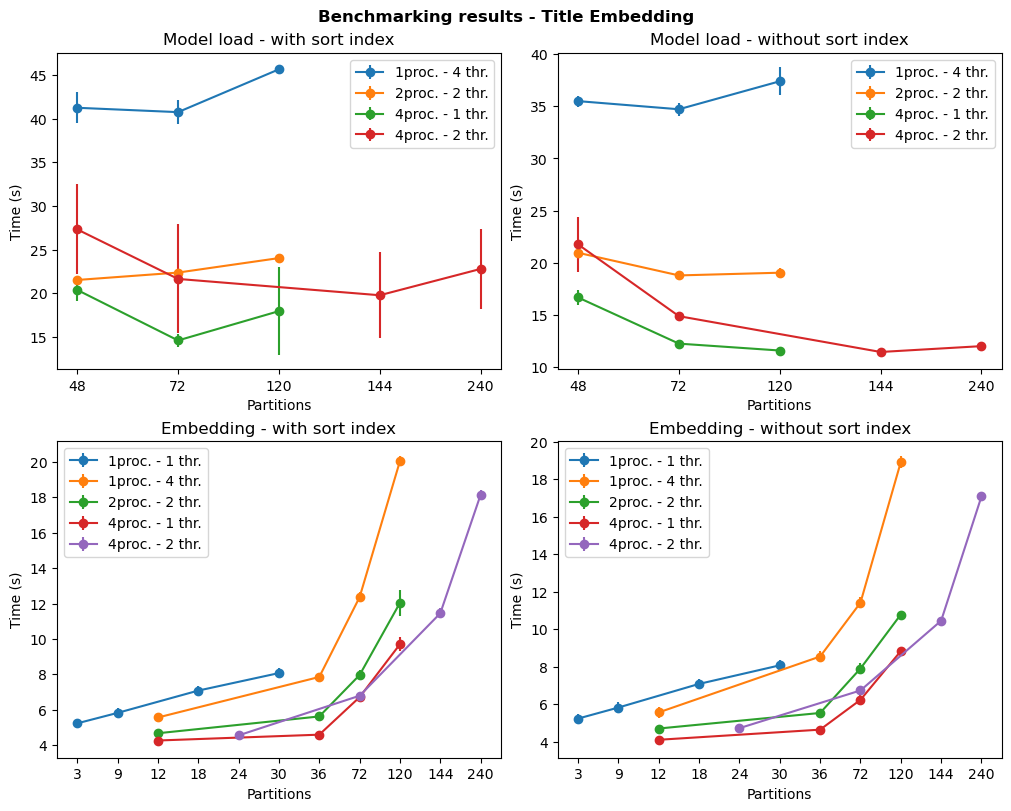

In [ ]:
fig, ax= plt.subplots(2,2,figsize=(10,8),layout='constrained')
fig.suptitle('Benchmarking results - Title Embedding',weight='bold')

f.plot_performances_2('bm/bm_3_mod_sortTrue.csv',j=0,k=0,ax=ax,title='Model load - with sort index')
f.plot_performances_2('bm/bm_3_mod_sortFalse.csv',j=0,k=1,ax=ax,title='Model load - without sort index')
f.plot_performances_2('bm/bm_3_emb_sortTrue.csv',ax=ax,title='Embedding - with sort index',j=1,k=0)
f.plot_performances_2('bm/bm_3_emb_sortFalse.csv',ax,'Embedding - without sort index', j=1,k=1)

plt.show()

Multi-processing works best for both operations, even though the difference in time for the embedding operation is a matter of seconds.

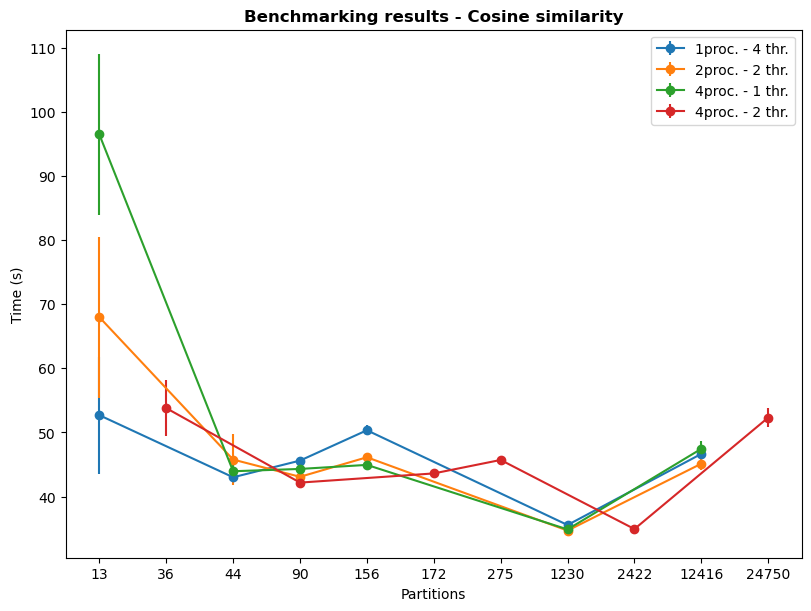

In [6]:
fig,ax=plt.subplots(1,1,figsize=(8,6),layout='constrained')
f.plot_performances_2('bm/bm_4.csv',ax,'Benchmarking results - Cosine similarity')

All cluster configurations seem to have similar performances with a minimum at $\sim100$ times the number of total threads.

In [19]:
client.shutdown()